## Import libraries

In [24]:
import io
import itertools

import numpy as np
import sklearn.metrics

import tensorflow as tf
from tensorboard.plugins.hparams import api as hp

import matplotlib.pyplot as plt

## Load and Preprocess data

In [25]:
train_data = np.load('dataset/Shoes - All - Train.npz')
validation_data = np.load('dataset/Shoes - All - Validation.npz')
test_data = np.load('dataset/Shoes - All - Test.npz')

In [26]:
train_data.files

['images', 'labels', 'genders']

In [27]:
images_train, labels_train = train_data['images'], train_data['labels']
images_val, labels_val = validation_data['images'], validation_data['labels']
images_test, labels_test = test_data['images'], test_data['labels']

In [28]:
images_train.shape

(4959, 120, 90, 3)

In [29]:
labels_train.shape

(4959,)

In [30]:
np.unique(labels_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [31]:
# Data augmentation
# Flip the image by flip the axis 2
# we have 4 axis now in images (no. of pic, y, x, channel)
# so, if we want to flip horizontally, we flip axis 2

flipped_images_train = np.flip(images_train, axis = 2)
flipped_images_val = np.flip(images_val, axis = 2)
flipped_images_test = np.flip(images_test, axis = 2)

In [32]:
# Don't forget to concatenate labels with itself, cuz we increase pic in images, so labels have to be increased too.
images_train = np.concatenate((images_train, flipped_images_train))
labels_train = np.concatenate((labels_train, labels_train))

images_val = np.concatenate((images_val, flipped_images_val))
labels_val = np.concatenate((labels_val, labels_val))

images_test = np.concatenate((images_test, flipped_images_test))
labels_test = np.concatenate((labels_test, labels_test))

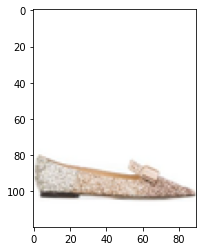

In [33]:
plt.imshow(images_train[5])

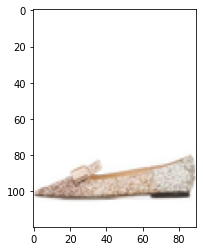

In [34]:
plt.imshow(images_train[4959+5])

In [35]:
images_val.shape

(1238, 120, 90, 3)

In [36]:
labels_val.shape

(1238,)

In [37]:
images_test.shape

(1238, 120, 90, 3)

In [38]:
labels_test.shape

(1238,)

In [39]:
# Scale the data
images_train = images_train/255.0
images_val = images_val/255.0
images_test = images_test/255.0

## Model Architecture

### Hyperparameters

In [40]:
EPOCHS = 15
BATCH_SIZE = 64

In [41]:
# Choose the best one from the tuning
# This was my mistake, I wrote the wrong code at the tuning so it saved only the last model.
# I need to do this again on the best hparam to save the best model
HP_KERNEL_SIZE = hp.HParam('kernel size', hp.Discrete([5]))
HP_KERNEL_NUM = hp.HParam('kernel num', hp.Discrete([128]))
HP_DROPOUT_RATE = hp.HParam('dropout rate', hp.Discrete([0.4]))

In [42]:
METRIC = 'accuracy'

with tf.summary.create_file_writer(r'logs\Model 1 (Shoes_All_Dropout)\hparam_tuning').as_default():
    hp.hparams_config(
        hparams = [HP_KERNEL_SIZE,HP_KERNEL_NUM,HP_DROPOUT_RATE],
        metrics = [hp.Metric(METRIC, display_name = 'accuracy')]
    )

### Model

In [43]:
def train_test_model(hparams, session_num):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(hparams[HP_KERNEL_NUM], hparams[HP_KERNEL_SIZE], activation = 'relu', input_shape = (120,90,3)),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
        tf.keras.layers.Conv2D(hparams[HP_KERNEL_NUM], hparams[HP_KERNEL_SIZE], activation = 'relu'),
        tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation = 'relu'),
        tf.keras.layers.Dropout(hparams[HP_DROPOUT_RATE]),
        tf.keras.layers.Dense(11, activation = 'softmax')
    ])
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy()
    model.compile(optimizer = 'adam', loss = loss_fn, metrics = ['accuracy'])
    
    log_dir = "Logs\\Model 1 (Shoes_All_Dropout)\\fit\\" + f"run-{session_num}"
    
    # functions for creating confusion matrix
    def plot_confusion_matrix(cm, class_names):
        """
        Returns a matplotlib figure containing the plotted confusion matrix.

        Args:
        cm (array, shape = [n, n]): a confusion matrix of integer classes
        class_names (array, shape = [n]): String names of the integer classes
        """
        figure = plt.figure(figsize=(12, 12))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title("Confusion matrix")
        plt.colorbar()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        # Normalize the confusion matrix.
        cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)

        # Use white text if squares are dark; otherwise black.
        threshold = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            color = "white" if cm[i, j] > threshold else "black"
            plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

        return figure

    def plot_to_image(figure):
        """Converts the matplotlib plot specified by 'figure' to a PNG image and
        returns it. The supplied figure is closed and inaccessible after this call."""

        # Save the plot to a PNG in memory.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')

        # Closing the figure prevents it from being displayed directly inside the notebook.
        plt.close(figure)

        buf.seek(0)

        # Convert PNG buffer to TF image
        image = tf.image.decode_png(buf.getvalue(), channels=4)

        # Add the batch dimension
        image = tf.expand_dims(image, 0)

        return image

    # Define a file writer variable for logging purposes
    file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')

    def log_confusion_matrix(epoch, logs):
        # Use the model to predict the values from the validation dataset.
        test_pred_raw = model.predict(images_val)
        test_pred = np.argmax(test_pred_raw, axis=1)

        # Calculate the confusion matrix.
        cm = sklearn.metrics.confusion_matrix(labels_val, test_pred)

        # Log the confusion matrix as an image summary.
        figure = plot_confusion_matrix(cm, class_names=['Boots Male','Trainers/Sneakers Male',
                                                        'Sandals/Flip flops/Slippers Male', 'Formal shoes Male',
                                                        'Others Male',
                                                        'Boots Female', 'Ballerina Female', 'Trainers/Sneakers Female',
                                                        'High heels Female', 'Sandals/Flip flops/Slippers Female',
                                                        'Others Female'])
        cm_image = plot_to_image(figure)

        # Log the confusion matrix as an image summary.
        with file_writer_cm.as_default():
            tf.summary.image("Confusion Matrix", cm_image, step=epoch)
            
    #callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True)
    cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end = log_confusion_matrix)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir, histogram_freq = 1, profile_batch = 0)
    
    model.fit(images_train,
              labels_train,
              epochs = EPOCHS,
              batch_size = BATCH_SIZE,
              callbacks = [tensorboard_callback, cm_callback, early_stopping],
              validation_data = (images_val, labels_val),
              verbose = 1)
    
    _, accuracy = model.evaluate(images_val, labels_val)
    
    model.save(r'saved_models\Model 1 (Shoes_All_Dropout)\Run-{}'.format(session_num))
    
    return accuracy

In [44]:
def run(log_dir, hparams, session_num):
    with tf.summary.create_file_writer(log_dir).as_default():
        hp.hparams(hparams)  # record the values used in this trial
        accuracy = train_test_model(hparams, session_num)
        tf.summary.scalar(METRIC,accuracy,step=1)

In [45]:
# This, again, the best model I got is from the 6th run
# First time I forgot the save the model, but I saved the hparam tuning result correctly
session_num = 18
for kernel_size in HP_KERNEL_SIZE.domain.values:
    for kernel_num in HP_KERNEL_NUM.domain.values:
        for dropout_rate in HP_DROPOUT_RATE.domain.values:
            hparams = {
                HP_KERNEL_SIZE : kernel_size,
                HP_KERNEL_NUM : kernel_num,
                HP_DROPOUT_RATE : dropout_rate
            }
            
            run_name = f'run-{session_num}'
            print('--- Starting Trial:',run_name)
            print({h.name: hparams[h] for h in hparams})
            run("Logs/Model 1 (Shoes_All_Dropout)/hparam_tuning/" + run_name, hparams, session_num)

            session_num += 1

--- Starting Trial: run-18
{'kernel size': 5, 'kernel num': 128, 'dropout rate': 0.4}
Epoch 1/15
155/155 [==============================] - 375s 2s/step - loss: 1.6478 - accuracy: 0.4734 - val_loss: 1.1942 - val_accuracy: 0.6300
Epoch 2/15
155/155 [==============================] - 350s 2s/step - loss: 1.0268 - accuracy: 0.6519 - val_loss: 0.8968 - val_accuracy: 0.6906
Epoch 3/15
155/155 [==============================] - 348s 2s/step - loss: 0.8030 - accuracy: 0.7187 - val_loss: 0.8446 - val_accuracy: 0.7068
Epoch 4/15
155/155 [==============================] - 361s 2s/step - loss: 0.6672 - accuracy: 0.7631 - val_loss: 0.7798 - val_accuracy: 0.7157
Epoch 5/15
155/155 [==============================] - 373s 2s/step - loss: 0.5811 - accuracy: 0.7879 - val_loss: 0.7931 - val_accuracy: 0.7383
Epoch 6/15
155/155 [==============================] - 387s 2s/step - loss: 0.4948 - accuracy: 0.8158 - val_loss: 0.7353 - val_accuracy: 0.7625
Epoch 7/15
155/155 [==============================] - 37